# Model training #1

For testing purposes only, on the simulated dataset, file savings are commented out.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.ensemble import RandomForestClassifier

# tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import AlphaDropout, Conv1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
tf.test.is_gpu_available(cuda_only=True)

### Data transformation/split:

In [2]:
featuretype = pd.read_csv('feature_types_final_simul.csv', sep=';')
df = pd.read_csv('data_clean_onehot_final_simulated.csv', sep=';')

# preprocess
df = df.sample(frac=1) # shuffle the data beforehand
dataset = df.dropna().values

# test and validation ratio
test_step = .1

# features and output
X = dataset[:,0:-1]
Y = dataset[:,-1]

# indexing
test_index = int(X.shape[0]*(1-test_step))

# test split
X_test = X[test_index:]
Y_test = Y[test_index:]
# Y_test = to_categorical(Y[test_index:],2)

# training split
X_train = X[:test_index]
Y_train = Y[:test_index]
# Y_train = to_categorical(Y[:test_index],2)


# MinMax scaling

scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)
y_train = Y_train.astype(int)
y_test = Y_test.astype(int)

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(45000, 45)
(45000,)
(5000, 45)
(5000,)


### Build the tf.keras.Sequential model by stacking layers.

Defaults are based on the hyper-parameter optimization.


In [4]:
def create_model(in_dim, dense_layer_sizes = 24, dropout_ratios = .4, depth = 7,
                 kernin = 'glorot_uniform', opti = 'adam', activ= 'selu'):
    
    model = Sequential()
    model.add(Dense(dense_layer_sizes,
                    activation=activ,
                    kernel_initializer=kernin,
                    input_shape=(in_dim,)))
    
#     note: for testing Conv1D as first layer (ditched since no visible improvement)
#     model.add(Conv1D(6, (6), activation=activ, input_shape=(32,1)))
#     model.add(Flatten())

    for i in range(depth-1): 
        model.add(Dropout(dropout_ratios))
        # model.add(BatchNormalization())
        # model.add(AlphaDropout(dropout_ratios))
        model.add(Dense(dense_layer_sizes,
                        activation=activ,
                        kernel_initializer=kernin))
        
    model.add(Dense(1, activation='sigmoid',
                    kernel_initializer=kernin)) # softmax if the output is shaped as 2-dim
    
    model.compile(optimizer=opti,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


Cross-validation training with callbacks:

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=40, verbose=1)
redlrplat = tf.keras.callbacks.ReduceLROnPlateau(patience=20, verbose=1)
#checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model1.hdf5', save_best_only=True, verbose=1)


# note: for testing Conv1D as first layer (ditched since no visible improvement)
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1],1)

skf = StratifiedKFold(n_splits=5, shuffle=True)

cross_histories = []
for train_index, valid_index in skf.split(x_train, y_train):
    model = create_model(in_dim = x_train.shape[1])
    
    # Train and evaluate model:
    network_history=model.fit(x_train[train_index], y_train[train_index], 
                batch_size=16, 
                epochs=10, 
                verbose=1,
                shuffle=True,
                validation_data=(x_train[valid_index], y_train[valid_index]), 
                callbacks=[early_stopping, redlrplat])
    cross_histories.append(network_history)

Train on 36000 samples, validate on 9000 samples
Epoch 1/10
36000/36000 [==============================] - 13s 349us/sample - loss: 0.6915 - accuracy: 0.5714 - val_loss: 0.6390 - val_accuracy: 0.6188
Epoch 2/10
36000/36000 [==============================] - 11s 297us/sample - loss: 0.6415 - accuracy: 0.6351 - val_loss: 0.6106 - val_accuracy: 0.6740
Epoch 3/10
36000/36000 [==============================] - 10s 284us/sample - loss: 0.6280 - accuracy: 0.6466 - val_loss: 0.6170 - val_accuracy: 0.6402
Epoch 4/10
36000/36000 [==============================] - 10s 286us/sample - loss: 0.6241 - accuracy: 0.6511 - val_loss: 0.6027 - val_accuracy: 0.6757
Epoch 5/10
36000/36000 [==============================] - 10s 271us/sample - loss: 0.6196 - accuracy: 0.6628 - val_loss: 0.6076 - val_accuracy: 0.6607
Epoch 6/10
36000/36000 [==============================] - 9s 261us/sample - loss: 0.6159 - accuracy: 0.6661 - val_loss: 0.5984 - val_accuracy: 0.6798
Epoch 7/10
36000/36000 [======================

In [10]:
# print("Evaluation")
# model.evaluate(x_test, Y_test)

def plot_history(network_histories, fp=None):
    plt.figure(figsize=(20,4))
    plt.subplot(2,2,1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    for network_history in network_histories:
        plt.plot(network_history.history['loss'])
    plt.legend(['Training'])

    plt.subplot(2,2,2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    for network_history in network_histories:
        plt.plot(network_history.history['acc'])
    plt.legend(['Training'], loc='lower right')

    plt.subplot(2,2,3)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    for network_history in network_histories:
        plt.plot(network_history.history['val_loss'])
    plt.legend(['Validation'])

    plt.subplot(2,2,4)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    for network_history in network_histories:
        plt.plot(network_history.history['val_acc'])
    plt.legend(['Validation'], loc='lower right')
    
#    plt.savefig(fp, bbox_inches='tight')
    plt.show()

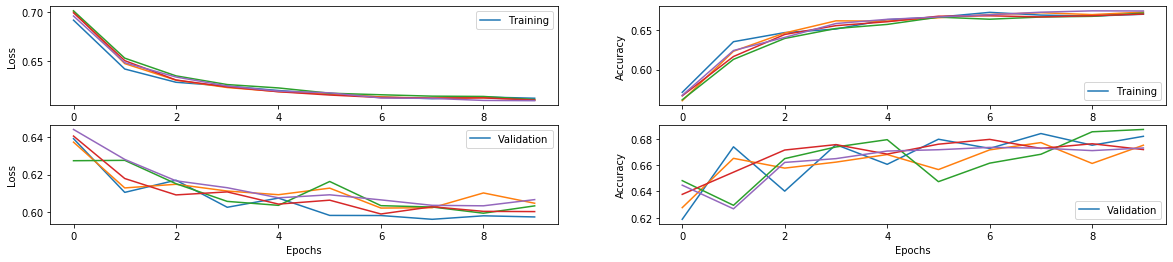

In [11]:
plot_history(cross_histories)#, 'model1_cross.pdf')

In [ ]:
# hhh= [ h.history for h in cross_histories ]
# pickle.dump( hhh, open( "cv_histories_1.p", "wb" ) )

## Alternative network structure

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=40, verbose=1)
redlrplat = tf.keras.callbacks.ReduceLROnPlateau(patience=20, verbose=1)
#checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model1.hdf5', save_best_only=True, verbose=1)


# note: for testing Conv1D as first layer (ditched since no visible improvement)
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1],1)

skf = StratifiedKFold(n_splits=5, shuffle=True)

cross_histories2 = []
for train_index, valid_index in skf.split(x_train, y_train):
    model2 = create_model(in_dim = x_train.shape[1],
                         dense_layer_sizes = 40, dropout_ratios = .4, depth = 6,
                      kernin = 'glorot_normal', opti = 'rmsprop', activ= 'relu')
    
    # Train and evaluate model:
    network_history2=model2.fit(x_train[train_index], y_train[train_index], 
                batch_size=16, 
                epochs=10, 
                verbose=1,
                shuffle=True,
                validation_data=(x_train[valid_index], y_train[valid_index]), 
                callbacks=[early_stopping, redlrplat])
    cross_histories2.append(network_history2)

Train on 36000 samples, validate on 9000 samples
Epoch 1/10
36000/36000 [==============================] - 9s 262us/sample - loss: 0.6509 - accuracy: 0.6204 - val_loss: 0.6193 - val_accuracy: 0.6702
Epoch 2/10
36000/36000 [==============================] - 8s 225us/sample - loss: 0.6296 - accuracy: 0.6568 - val_loss: 0.6162 - val_accuracy: 0.6826
Epoch 3/10
36000/36000 [==============================] - 8s 219us/sample - loss: 0.6258 - accuracy: 0.6607 - val_loss: 0.6309 - val_accuracy: 0.6754
Epoch 4/10
36000/36000 [==============================] - 9s 240us/sample - loss: 0.6266 - accuracy: 0.6670 - val_loss: 0.6202 - val_accuracy: 0.6711
Epoch 5/10
36000/36000 [==============================] - 8s 215us/sample - loss: 0.6239 - accuracy: 0.6683 - val_loss: 0.6101 - val_accuracy: 0.6839
Epoch 6/10
36000/36000 [==============================] - 8s 213us/sample - loss: 0.6252 - accuracy: 0.6711 - val_loss: 0.6164 - val_accuracy: 0.6809
Epoch 7/10
36000/36000 [===========================

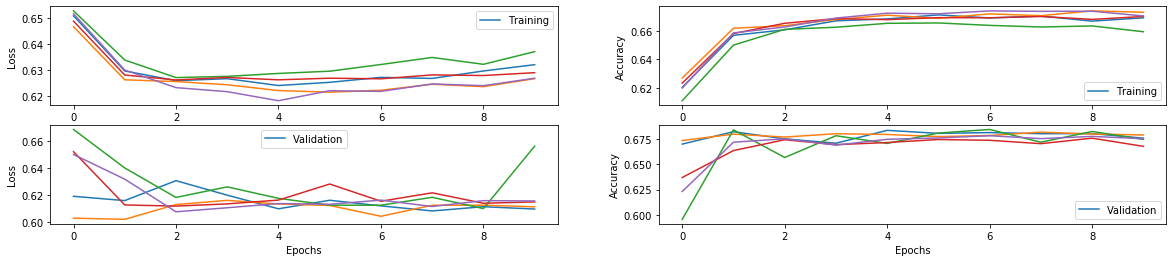

In [13]:
plot_history(cross_histories2)#, 'model2_cross.pdf')

In [ ]:
# hhh2= [ h.history for h in cross_histories2 ]
# pickle.dump( hhh2, open( "cv_histories_2.p", "wb" ) )

# Final model

In [5]:
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=60, verbose=1)
redlrplat = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=30, verbose=1)
# checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model_final.hdf5', save_best_only=True, verbose=1)


# my_classifier = KerasClassifier(create_model,
#                                 in_dim = x_train.shape[1],
#                                 batch_size=16, 
#                                 epochs=50, 
#                                 verbose=1,
#                                 shuffle=True,
#                                 validation_data=(x_test, y_test), 
#                                 callbacks=[early_stopping, redlrplat])

# fitted_history = my_classifier.fit(x_train, y_train)

model = create_model(in_dim = x_train.shape[1])
# Train and evaluate model:
network_history=model.fit(x_train, y_train, 
            batch_size=16, 
            epochs=50, 
            verbose=1,
            shuffle=True,
            validation_data=(x_test, y_test), 
            callbacks=[early_stopping, redlrplat])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 12s 271us/sample - loss: 0.6950 - acc: 0.5714 - val_loss: 0.6235 - val_acc: 0.6630
Epoch 2/50
45000/45000 [==============================] - 11s 247us/sample - loss: 0.6384 - acc: 0.6359 - val_loss: 0.6099 - val_acc: 0.6822
Epoch 3/50
45000/45000 [==============================] - 11s 246us/sample - loss: 0.6253 - acc: 0.6563 - val_loss: 0.6216 - val_acc: 0.6688
Epoch 4/50
45000/45000 [==============================] - 12s 258us/sample - loss: 0.6188 - acc: 0.6604 - val_loss: 0.6021 - val_acc: 0.6690
Epoch 5/50
45000/45000 [==============================] - 12s 273us/sample - loss: 0.6158 - acc: 0.6677 - val_loss: 0.6002 - val_acc: 0.6848
Epoch 6/50
45000/45000 [==============================] - 11s 244us/sam

In [6]:
# my_classifier.model.save("model_final2.hdf5")
model.save("model_simulated.hdf5")

In [15]:
def plot_history_onemodel(network_history, fp=None):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Test'])

    plt.subplot(1,2,2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Test'], loc='lower right')
    
#     plt.savefig(fp, bbox_inches='tight')
    plt.show()

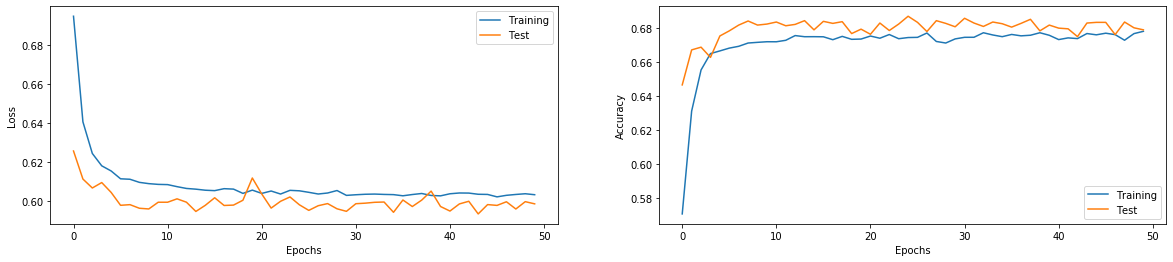

In [16]:
plot_history_onemodel(fitted_history)#, "final_model.pdf")

## XGBoost
for comparison with the NN model

In [18]:
gbtree = xgboost.XGBClassifier(objective='binary:logistic',
                               eta=0.01, max_depth=3, colsample_bytree=0.75, n_estimators=200)
gbtree.fit(x_train, y_train)

print(accuracy_score(y_train, gbtree.predict(x_train)))
print(accuracy_score(y_test, gbtree.predict(x_test)))

0.7202
0.698


## RandomForest
for comparison with the NN model

In [19]:
rfmod = RandomForestClassifier(n_estimators=100, max_depth= 5)
rfmod.fit(x_train, y_train)

print(rfmod.score(x_train,y_train))
print(rfmod.score(x_test, y_test))

0.6777777777777778
0.6732


reload the NN model:

In [20]:
# finmod = tf.keras.models.load_model("model_simulated.hdf5")
# finmod = my_classifier.model
finmod = model

In [21]:
finmod.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 24)                1104      
_________________________________________________________________
dropout_55 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_56 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_57 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 24)              

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def roccc(model, modelname, tfkeras = False):
    if tfkeras:
        y_hat = model.predict(x_test)
    else:
        y_hat = model.predict_proba(x_test)[:,1]
        

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr[0], tpr[0], _ = roc_curve(y_test, y_hat)
    roc_auc[0] = auc(fpr[0], tpr[0])

#     # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_hat.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    ROC = plt.plot(fpr[0], tpr[0],
         lw=lw, label = modelname + ' ROC (area = %0.2f)' % roc_auc[0])
    
    return fpr, tpr, roc_auc

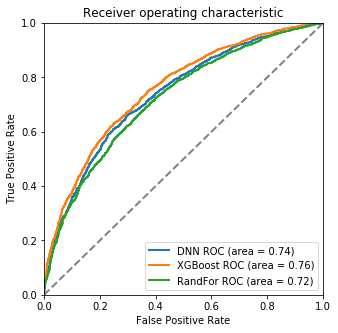

In [23]:
plt.figure(figsize=(5,5))

roccc(finmod, tfkeras=True, modelname = 'DNN')
roccc(gbtree, modelname = 'XGBoost')
roccc(rfmod, modelname = 'RandFor')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# plt.savefig('roc_compa.pdf', bbox_inches='tight')
plt.show()

# Bagging estimator

In [ ]:
from sklearn.ensemble import BaggingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_sklearn_model():

# note: sadly, bagging with different models is not allowed
#     dens = np.random.choice([16,24,32,40])
#     dep = np.random.choice([3,4,5,6,7])
#     act = np.random.choice(['selu', 'relu', 'sigmoid'])
#     drop =np.random.choice([.2,.3,.4,.5])
    
    my_classifier = KerasClassifier(create_model,
                                    in_dim=x_train.shape[1],
                                    dense_layer_sizes = 24,
                                    dropout_ratios = .4,
                                    depth = 7,
                                    activ= 'selu',
                                batch_size=16, 
                                epochs=50, 
                                verbose=1,
                                shuffle=True)
    return my_classifier


bagclf = BaggingClassifier(base_estimator=create_sklearn_model(),
                           n_estimators=10,
                           random_state=0,
                          bootstrap=True)

bagclf.fit(x_train, y_train)

In [ ]:
bagclf.score(x_test, y_test)

In [ ]:
from sklearn.metrics import plot_roc_curve

bagclf_disp = plot_roc_curve(bagclf, x_train, y_train)
bagclf_disp.figure_.suptitle("ROC curve comparison")

plt.show()